# 變數命名規則


* df : 代表具有資料庫中所有圖片的特徵標籤的data frame <br>
* filtered_df : 經過『Category』、『Pattern』、以及『Color』三次篩選過後的data frame 
* input_path : 代表使用者輸入的圖片所在的路徑<br>
* input_img : 透過PIL.Image讀入input_path的圖檔<br>
* input_color_labels : 為一dict結構，存放使用者輸入的圖片經過分析後所得到的『主色』及『副色』<br>
* input_img_vector : 為cv2讀入之三維陣列，代表使用者輸入的圖片的陣列格式<br>
* input_img_vector_gray : 為一維陣列，代表使用者輸入的圖片經過灰階後的陣列格式<br>
* input_hashstr : 為長度4096之零一字串，代表使用者輸入的圖片經過灰階、灰度計算後所轉成的字串<br>
* hd_dict : 為一dict結構，存放經過相似度計算排序後，由最相似到最不相似排序的資料庫圖片之路徑<br>

* 顏色：共39個顏色標籤，包含Black、White、Gray，以及Color Table中12種顏色的三種明亮度變化（例如：Dark Red、Red、Light Red）

# I. Package

In [1]:
# !pip3 install colorthief

# Package import
import pandas as pd
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from colorthief import ColorThief
import os

# II. General 

In [2]:
df = pd.read_csv('HSL色標完整檔.csv')

# III. Input image

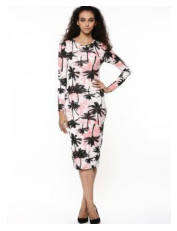

In [160]:
"""
# 讓使用者上傳圖片的地方
# 注意：這邊我先Random挑出一張資料庫中的圖片作為範例input
"""
input_index = np.random.randint(143229)
input_path = 'cvat_pictures/%s/%s/%s'%(df.iloc[input_index, 1], df.iloc[input_index, 3], df.iloc[input_index, 2])
input_img = Image.open(input_path)
plt.imshow(input_img)
plt.axis('off')
plt.show()

# IV. Filter 1: Category and Patterns

In [178]:
"""
種類與花紋篩選
category_recog_training與pattern_recog_training
"""

filtered_df = df
filtered_df = df[df['clothing'] == df['clothing'][input_index]]
filtered_df

# V. Filter 2: Color   （主要修改區域）

In [174]:
# RGB通道轉HSL通道，數學公式參考 https://zh.wikipedia.org/wiki/HSL和HSV色彩空间
def RGB2HSL(R, G, B):
    
    R = R / 255
    G = G / 255
    B = B / 255
    Cmax = max(R, G, B)
    Cmin = min(R, G, B)
    Delta = Cmax - Cmin
    
    if Delta == 0:
        return (0, 0, int((Cmax + Cmin) * 50))
    else:
        if Cmax == R:
            return (int((60 * ((G - B) / Delta) + 360) % 360), 
                    int((Delta / (1 - abs((Cmax + Cmin) - 1))) * 100),
                    int((Cmax + Cmin) * 50))
        elif Cmax == G:
            return (int((60 * ((B - R) / Delta) + 120) % 360), 
                    int((Delta / (1 - abs((Cmax + Cmin) - 1))) * 100), 
                    int((Cmax + Cmin) * 50))
        else:
            return (int((60 * ((R - G) / Delta) + 240) % 360),
                    int((Delta / (1 - abs((Cmax + Cmin) - 1))) * 100),
                    int((Cmax + Cmin) * 50))

# HSL通道轉RGB通道
def HSL2RGB(H, S, L):
    
    S = S / 100
    L = L / 100
    
    C = L * S
    H = H / 60
    X = C * (1 - abs(H % 2 - 1))
    m = L - C
    
    if 0 <= H <= 1:
        (R, G, B) = (C, X, 0)
    elif 1 < H <= 2:
        (R, G, B) = (X, C, 0)
    elif 2 < H <= 3:
        (R, G, B) = (0, C, X)
    elif 3 < H <= 4:
        (R, G, B) = (0, X, C)
    elif 4 < H <= 5:
        (R, G, B) = (X, 0, C)
    elif 5 < H <= 6:
        (R, G, B) = (C, 0, X)
        
    return (int((R + m) * 255), int((G + m) * 255), int((B + m) * 255))


# 從HSL通道轉為39種顏色標籤其中之一
def get_color(HSL_Channel):
    
    ColorTable = {
        'Red': list(np.arange(0, 15, 1)) + list(np.arange(345, 361, 1)),
        'Orange': range(15, 45),
        'Yellow': range(45, 75),
        'Spring Green': range(75, 105),
        'Green': range(105, 135),
        'Turquoise': range(135, 165),
        'Cyan': range(165, 195),
        'Ocean': range(195, 225),
        'Blue': range(225, 255),
        'Violet': range(255, 285),
        'Magenta': range(285, 315),
        'Raspberry': range(315, 345)
                 }
        
    H, S, L = HSL_Channel[0], HSL_Channel[1], HSL_Channel[2]
    
    if S < 10: # 飽和度不滿10%，屬於黑白灰
        if L > 80:
            return 'White'
        elif L < 35:
            return 'Black'
        else:
            return 'Gray'
    
    elif 10 <= S < 45:  # 飽和度介於10 - 45%
        if L < 25:
            return 'Black'
        elif L > 85:
            return 'White'
        elif 25 <= L < 40:
            for ColorRange in ColorTable.items():
                    if H in ColorRange[1]:
                        return 'Dark ' + ColorRange[0]
        elif 40 <= L < 60:
            for ColorRange in ColorTable.items():
                    if H in ColorRange[1]:
                        return ColorRange[0]
        else:
            for ColorRange in ColorTable.items():
                if H in ColorRange[1]:
                    return 'Light ' + ColorRange[0]
        
    else: # 飽和度大於45%，屬於其他顏色
        if L < 20: # 亮度小於25%，屬於黑色
            return 'Black'
        elif L > 90:
            return 'White'  
        elif 20 <= L < 35:
            for ColorRange in ColorTable.items():
                    if H in ColorRange[1]:
                        return 'Dark ' + ColorRange[0]
        elif 35 <= L < 70:
            for ColorRange in ColorTable.items():
                    if H in ColorRange[1]:
                        return ColorRange[0]
        else:
            for ColorRange in ColorTable.items():
                if H in ColorRange[1]:
                    return 'Light ' + ColorRange[0]
                
                
# 利用Colorthief這個模組挑出圖片中的三個主要顏色的RGB色碼                
def get_color_palette(img_path):  # 輸入為圖片的path
    
    image = Image.open(img_path)  # 讀入檔案
    image = image.convert("RGB")  # 統一轉成RGB格式
    image = image.resize((64,64))  # 統一轉成64*64大小
    image = image.crop((int(image.width * (1/3)), int(image.height * (1/3)), 
                        int(image.width * (2/3)), int(image.height * (2/3))))  # 影像裁切，目的為盡可能只保留中間區域
    image.save('cvat_pictures/temp/temp.jpg')  # 因為colorthief沒有提供裁切功能，因此我採用手動裁切，然後將裁切過的圖片先存成一個temp.jpg的檔案
    
    color_thief = ColorThief('cvat_pictures/temp/temp.jpg')  # colorthief再讀取此temp.jpg檔案做顏色分析
    color_palette = color_thief.get_palette(color_count = 2) # 只取一個主色及兩個副色
    os.remove('cvat_pictures/temp/temp.jpg')  # 分析完成後，刪除才切過的那張圖片

    color_labels = []   # 用來存主色與副色，第一值為主色，後續值為副色
    
    for i, v in enumerate(color_palette):

        color = RGB2HSL(v[0], v[1], v[2])
        color = get_color(color)
        
        if color not in color_labels:  # 避免主副色重複
            color_labels.append(color)
    
    return color_labels 

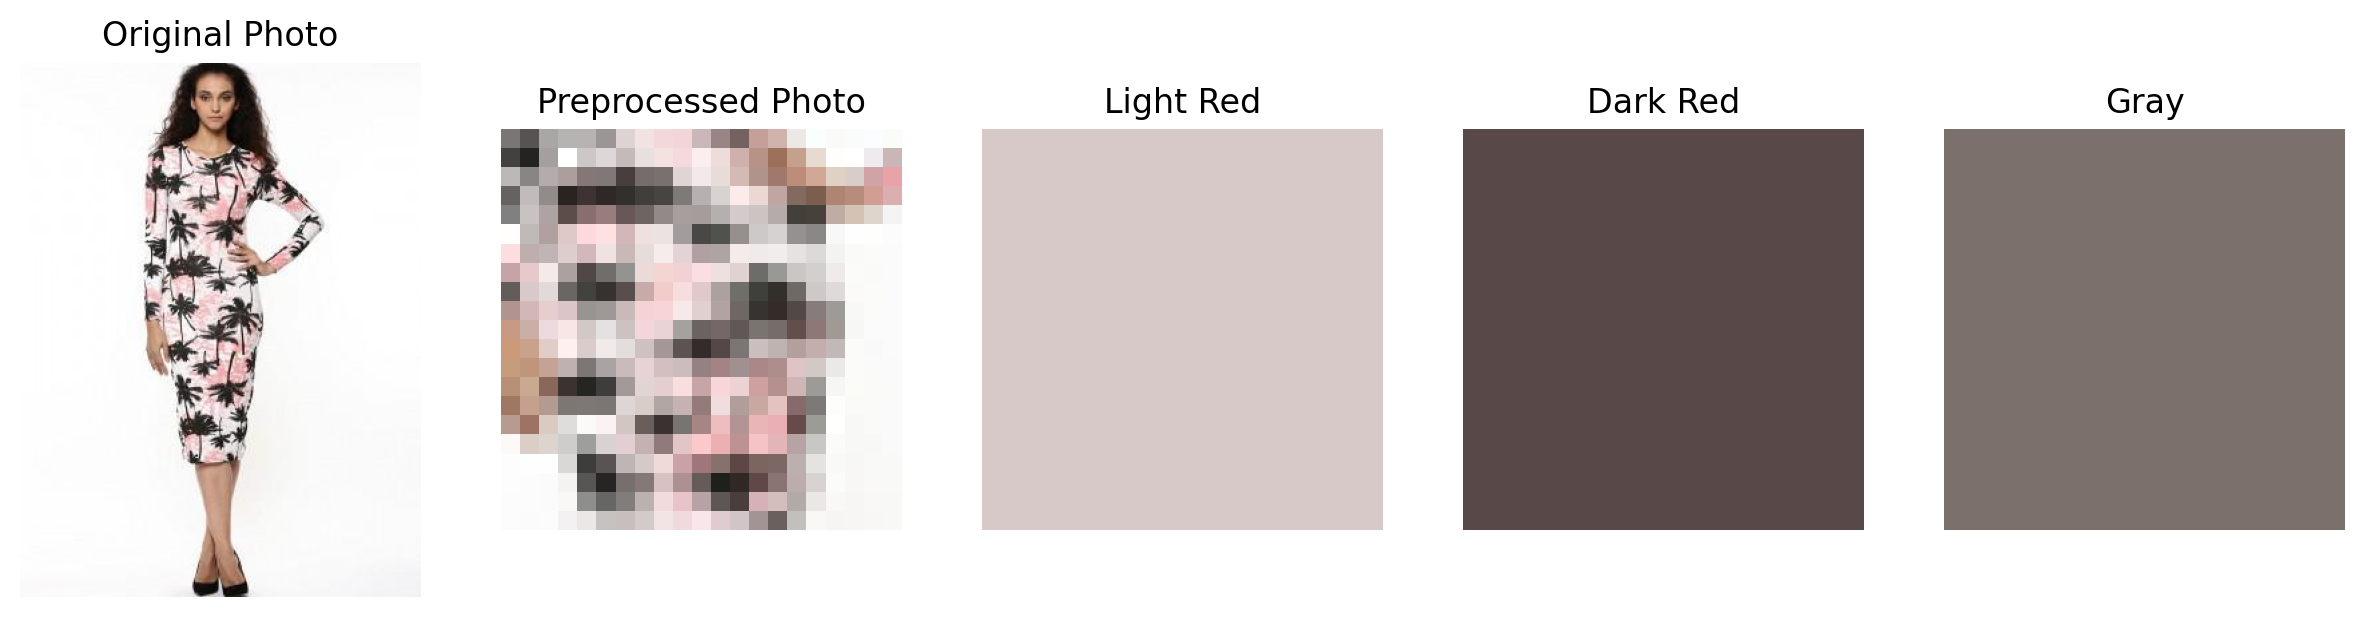

(215, 201, 200) (4, 15, 81)
(89, 72, 72) (0, 10, 31)
(124, 112, 108) (15, 6, 45)


In [176]:
# 測試用，最後請刪除

def test_get_color_palette(img_path):
    
    image = Image.open(img_path)  # 讀入檔案
    image = image.convert("RGB")  # 統一轉成RGB格式
    image = image.resize((64,64))  # 統一轉成64*64大小
    image = image.crop((int(image.width * (1/3)), int(image.height * (1/3)), 
                        int(image.width * (2/3)), int(image.height * (2/3))))  # 影像裁切，目的為盡可能只保留中間區域
    image.save('cvat_pictures/temp/temp.jpg')  # 因為colorthief沒有提供裁切功能，因此我採用手動裁切，然後將裁切過的圖片先存成一個temp.jpg的檔案

    color_thief = ColorThief('cvat_pictures/temp/temp.jpg')  # colorthief再讀取此temp.jpg檔案做顏色分析
    color_palette = color_thief.get_palette(color_count = 2) # 只取一個主色及兩個副色
    os.remove('cvat_pictures/temp/temp.jpg')  # 分析完成後，刪除才切過的那張圖片

    color_labels = []   # 用來存主色與副色，第一值為主色，後續值為副色

    for i, v in enumerate(color_palette):

        color = RGB2HSL(v[0], v[1], v[2])
        color = get_color(color)

        if color not in color_labels:  # 避免主副色重複
            color_labels.append(color)
        
    return image, color_labels, color_palette  # 回傳為一個dict，內存主色和副色 


img, color, palette = test_get_color_palette(input_path)

fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(nrows = 1, ncols = 5, figsize = (15,8), dpi = 200)


ax0.imshow(input_img)
ax0.set_title('Original Photo')
ax0.axis('off')


ax1.imshow(img)
ax1.set_title('Preprocessed Photo')
ax1.axis('off')

ax2.imshow([[palette[0]]])
ax2.set_title(color[0])
ax2.axis('off')

ax3.imshow([[palette[1]]])
ax3.set_title(color[1])
ax3.axis('off')

ax4.imshow([[palette[2]]])
ax4.set_title(color[2])
ax4.axis('off')

plt.show()
for i in palette:
    print((i[0], i[1], i[2]), (RGB2HSL(i[0], i[1], i[2])))

In [166]:
### filter顏色 ###

# 找出input圖片中的主色及副色為何
input_color_labels = get_color_palette(input_path)

# 在第一步驟，只用主色作為篩選條件

filtered_df = filtered_df[filtered_df['main_color'] == input_color_labels[0]]  
# filtered_df = filtered_df[filtered_df['sub_color.1'] == input_color_labels[1]] 

# VI. Convert to binary string and calculate similarity

In [167]:
# Functions to perform image converting into string

# 將圖片轉為binary string
def IMG2HASH(img):
    hashstr = str()
    avg = np.mean(img)
    for i in range(64):                  
            for j in range(64):
                if  img[i,j] > avg:
                    hashstr = hashstr + '1'
                else:
                    hashstr = hashstr + '0'
    return hashstr

# 計算兩個binary string的差異性（相似性）
def HammingDist(A, B):
    HD = 0
    str_len = len(A)
    for i in range(str_len):
        if A[i] != B[i]:
            HD += 1
    return HD

# 圖片裁切
def IMGCrop(IMG):
    x = int(IMG.shape[1]/6)
    y = int(IMG.shape[0]/6)

    w = int(IMG.shape[1] * (2/3))
    h = int(IMG.shape[0] * (2/3))

    return IMG[y: y+h, x: x+w]

# 將長度為4096的binary string做encoding，縮減長度
def encode(bin_string):
    charset = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-_'
    chunks = [bin_string[i:i+6] for i in range(0, len(bin_string), 6)]
    last_chunk_length = len(chunks[-1])
    decimals = [int(chunk, 2) for chunk in chunks]
    decimals.append(last_chunk_length)
    ascii_string = ''.join([charset[i] for i in decimals])

    return ascii_string

# 將encoded的字串做decode，回復成長度為4096的binary string
def decode(ascii_string):
    charset = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-_'
    decimals = [charset.index(char) for char in ascii_string]
    last_chunk_length, last_decimal = decimals.pop(-1), decimals.pop(-1)
    bin_string = ''.join([bin(decimal)[2:].zfill(6) for decimal in decimals])
    bin_string += bin(last_decimal)[2:].zfill(last_chunk_length)

    return bin_string



# 將輸入影像轉為binary string
input_img_vector = cv2.imread(input_path)  # 以三維陣列讀入圖片
input_img_vector = cv2.resize(input_img_vector, (64,64), interpolation = cv2.INTER_CUBIC)  # 圖片大小改為64*64
input_img_vector_gray = cv2.cvtColor(input_img_vector, cv2.COLOR_BGR2GRAY)  # 影像灰階化
input_hashstr = IMG2HASH(input_img_vector_gray)  # 將影像轉為Binary string

# VII. Return address based on similarity ranking

In [169]:
# 計算input影像與filtered過後的資料庫中其他影像的相似性，並做排序
hd_dict = {}

for i, v in enumerate(filtered_df['encoding']):

    path = 'cvat_pictures/%s/%s/%s'%(df.iloc[filtered_df['encoding'].index[i], 1],
                                     df.iloc[filtered_df['encoding'].index[i], 3], 
                                     df.iloc[filtered_df['encoding'].index[i], 2])
    
    hd_dict[path] = HammingDist(input_hashstr, decode(v))
    
hd_dict = dict(sorted(hd_dict.items(), key = lambda item: item[1]))  # 此hd_dict中的keys即為圖片所在路徑

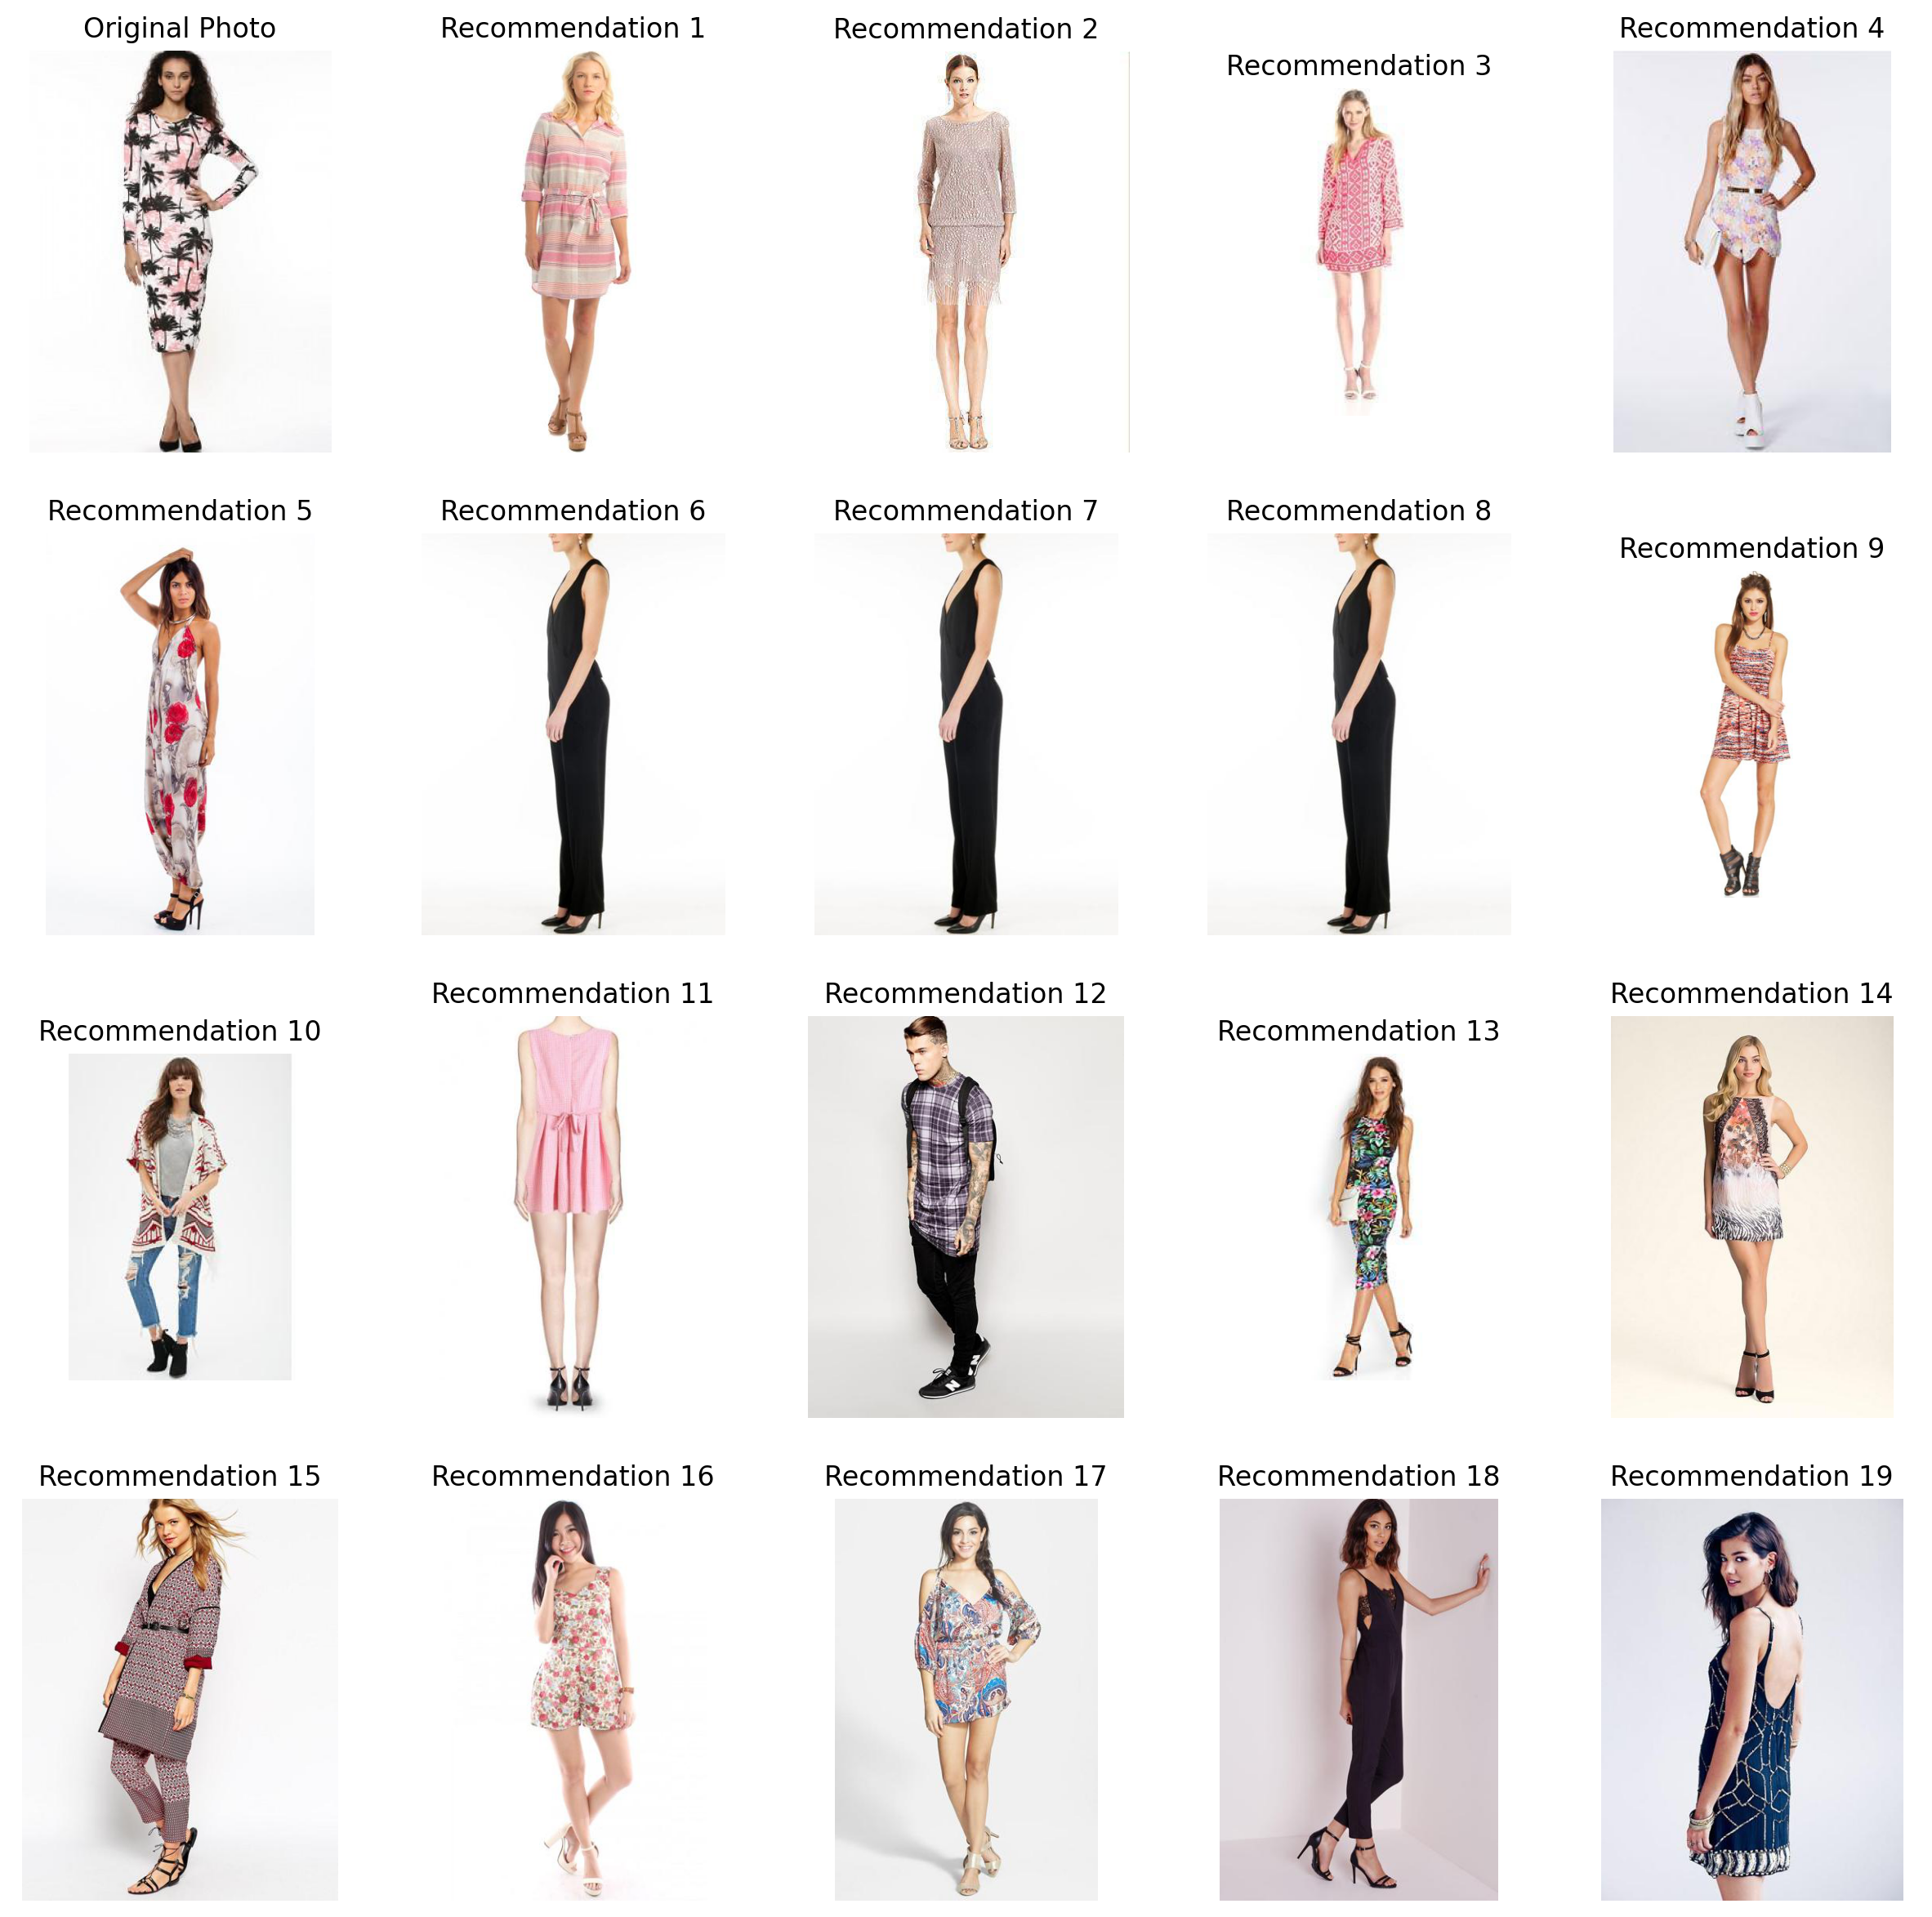

<Figure size 432x288 with 0 Axes>

In [170]:
# 結果呈現，（僅參考，不需要放入code中）
plt.figure(figsize = (15, 15), dpi = 200)

loc = 1
for path in list(hd_dict.keys())[:20]:
    if loc == 1:
        img = Image.open(path)
        plt.subplot(4, 5, loc)
        plt.title('Original Photo')
        plt.axis('off')
        plt.imshow(img)
        loc+=1
        
    else:
        img = Image.open(path)
        plt.subplot(4, 5, loc)
        plt.title('Recommendation %d'%(loc-1))
        plt.axis('off')
        plt.imshow(img)
        loc+=1
    
plt.show()

plt.savefig('編號117337，未考慮種類.png')